In [192]:
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import missingno as msno
import tqdm

In [113]:
# data directory
DATA_DIR = '../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub_with_rule.csv'

# 検索ログ csv
SEARCH_LOG_DIR = lambda month: f'{DATA_DIR}/search_records/csv{month}'
SEARCH_LOG_CSV = lambda date: f'{SEARCH_LOG_DIR(date[:6])}/record_{date}.csv'

# 検索件数 csv
SEARCH_COUNT_TATEYAMA_CSV = f'{DATA_DIR}/search_count/tateyama_spec.csv'
SEARCH_COUNT_KANNETSU_CSV = f'{DATA_DIR}/search_count/kannetsu_spec.csv'

UNSPECIFIED_SEARCH_COUNT_TATEYAMA_CSV = f'{DATA_DIR}/search_count/tateyama_unspec.csv'
UNSPECIFIED_SEARCH_COUNT_KANNETSU_CSV = f'{DATA_DIR}/search_count/kannetsu_unspec.csv'

# 交通量 csv
TRAFFIC_TATEYAMA_CSV = f'{DATA_DIR}/traffic/tateyama_20220621all-merged_filled.csv'
TRAFFIC_KANNETSU_CSV = f'{DATA_DIR}/traffic/kannetsu_20220621all-merged_filled.csv'

TRAFFIC_TATEYAMA_15MIN_CSV = f'{DATA_DIR}/traffic/tateyama_20220621all-merged_filled_15min.csv'
TRAFFIC_KANNETSU_15MIN_CSV = f'{DATA_DIR}/traffic/kannetsu_20220621all-merged_filled_15min.csv'

# 渋滞予測 csv
JAM_PRED_CSV = f'{DATA_DIR}/jam_data/jam_prediction_R4GW_filled.csv'

In [3]:
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

## 渋滞実績データの可視化

In [7]:
replace_map = {
    '1130039': '1130036',
    '1800146': '1800151',
    '1800072': '1800073'
}

col_types = {
  'start_code': str,
  'end_code': str,
  'jam_type': str,
  'road_code': str
}

In [204]:
df_kannetsu['jam_type'].value_counts() / df_kannetsu['jam_type'].value_counts().sum()

交通集中          0.536118
事故            0.230324
その他           0.120832
交通集中（アクセス）    0.078551
工事            0.034174
Name: jam_type, dtype: float64

In [205]:
df_tateyama['jam_type'].value_counts() / df_tateyama['jam_type'].value_counts().sum()

交通集中    0.769458
その他     0.104390
事故      0.077093
工事      0.049059
Name: jam_type, dtype: float64

In [8]:
df_tateyama = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index(drop=True)
df_tateyama.replace(replace_map, inplace=True)
df_kannetsu = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index(drop=True)
df_kannetsu.replace(replace_map, inplace=True)

In [18]:
df_tateyama['jam_flag'] = np.where(df_tateyama['jam_quantity'] > 0, True, False)
df_kannetsu['jam_flag'] = np.where(df_kannetsu['jam_quantity'] > 0, True, False)

In [34]:
def fillna(df, col):
    f = lambda g: g.interpolate(method='linear', axis=0)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df

print(df_kannetsu['speed'].isna().sum())
df_tateyama = fillna(df_tateyama, 'speed')
df_kannetsu = fillna(df_kannetsu, 'speed')
print(df_kannetsu['speed'].isna().sum())

35868
0


In [ ]:
df_tateyama['speed'].fillna(method='ffill', inplace=True)
df_kannetsu['speed'].fillna(method='ffill', inplace=True)

In [118]:
df_jam_pred

,datetime,start_code,end_code,jam_flag,road_code
0,2022-04-29 00:00:00,1800006,1110210,False,1800
1,2022-04-29 00:05:00,1800006,1110210,False,1800
2,2022-04-29 00:10:00,1800006,1110210,False,1800
3,2022-04-29 00:15:00,1800006,1110210,False,1800
4,2022-04-29 00:20:00,1800006,1110210,False,1800
...,...,...,...,...,...
227515,2022-05-08 23:35:00,1130041,1130046,False,1130
227516,2022-05-08 23:40:00,1130041,1130046,False,1130
227517,2022-05-08 23:45:00,1130041,1130046,False,1130
227518,2022-05-08 23:50:00,1130041,1130046,False,1130


In [133]:
df_jam_pred = pd.read_csv(JAM_PRED_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index()
df_jam_pred.replace(replace_map, inplace=True)

df_tat_pred = df_jam_pred.loc[df_jam_pred['road_code'] == '1130']
df_kan_pred = df_jam_pred.loc[df_jam_pred['road_code'] == '1800']

In [9]:
net_cols = ['start_code', 'end_code', 'road_code', 'distance', 'direction']

tateyama_net = df_tateyama.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]
kannetsu_net = df_kannetsu.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]

df_icnet = pd.concat([tateyama_net, kannetsu_net])
df_icnet.replace(replace_map, inplace=True)

ic_graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                  edge_attr=['road_code', 'direction'],
                                  create_using=nx.DiGraph())

In [35]:
print(f'渋滞発生割合: {df_tateyama["jam_flag"].sum() / len(df_tateyama) * 100: .3f}%')

渋滞発生割合:  0.132%


In [36]:
print(f'渋滞発生割合: {(df_tateyama["speed"] < 40).sum() / len(df_tateyama) * 100: .3f}%')

渋滞発生割合:  0.063%


In [37]:
print(f'渋滞発生割合: {df_kannetsu["jam_flag"].sum() / len(df_kannetsu) * 100: .3f}%')

渋滞発生割合:  0.488%


In [38]:
print(f'渋滞発生割合: {(df_kannetsu["speed"] < 40).sum() / len(df_kannetsu) * 100: .3f}%')

渋滞発生割合:  0.604%


In [39]:
df_kannetsu['jam_flag']

0          False
1          False
2          False
3          False
4          False
           ...  
8110363    False
8110364    False
8110365    False
8110366    False
8110367    False
Name: jam_flag, Length: 8110368, dtype: bool

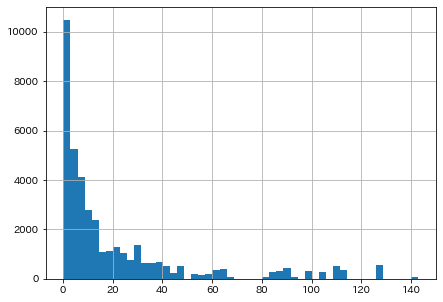

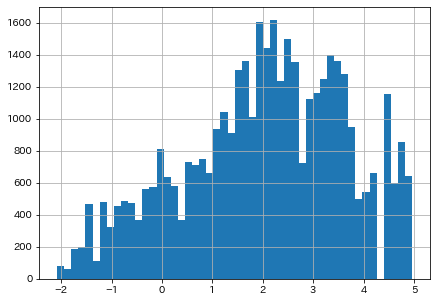

In [40]:
jam_neq0 = df_kannetsu.loc[df_kannetsu['jam_flag'], 'jam_quantity']
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(jam_neq0, bins=50)
ax.grid()

fig, ax = plt.subplots(figsize=(7,5))
ax.hist(np.log(jam_neq0), bins=50)
ax.grid()
plt.show()

### by ヒートマップ

In [27]:
def get_oneday(df, date, format='%Y%m%d'):
    '''
    1日分だけdfから取得する
    '''
    cond = df['datetime'].dt.date == dt.datetime.strptime(date, format).date()
    return df.loc[cond].reset_index(drop=True)

In [28]:
def get_ic_order(df, direction):
    '''
    dfは特定道路についてのデータだと仮定して, その道路上のicの順番を得る
    '''
    def one_road_graph(df, direction):
        '''
        dfは特定道路についてのデータだと仮定して, その道路のグラフを構築する
        '''
        df_icnet = df.drop_duplicates(['start_code', 'end_code', 'direction']).reset_index(drop=True)
        df_icnet = df_icnet.loc[df_icnet['direction'] == direction]
        graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                          edge_attr=['road_code', 'direction'],
                                          create_using=nx.DiGraph())
        return graph
    
    ic_graph = one_road_graph(df, direction)
    # グラフ上をtraverseしてICの順番を得る
    nodes = nx.dfs_postorder_nodes(ic_graph)
    nodes = list(nodes)[::-1]
    ic_order_map = {code: i for i, code in enumerate(nodes)}
    return ic_order_map

In [29]:
def init_mat(ic_order, sr):
    '''
    ic_orderが並ぶ道路でサンプリングレートsrで取得したデータをヒートマップにする時の行列を初期化する
    '''
    assert sr[-1] == 'h' or sr[-3:] == 'min', 'sampling rate error'
    
    dt_format = '%H:%M'
    if sr[-1] == 'h':
        periods = 24 // int(sr[:-1])
    else:
        periods = 24 * 60 // int(sr[:-3])
    ts = [t.strftime(dt_format) for t in pd.date_range('20220101', periods=periods, freq=sr)]
    
    mat = np.zeros((len(ts), len(ic_order)-1))
    return mat, ts


def get_mat(df, ic_order, direction, sr, num_col, time_col='datetime'):
    '''
    dfのnum_colカラムに入っている値を IC x 時間 の行列に格納する
    道路の方向はdirection, サンプリングレートはsr, 日時情報の入ったカラムはtime_colで指定する
    '''
    mat, ts = init_mat(ic_order, sr)
    ts_map = {t: i for i, t in enumerate(ts)}
    
    for i, row in df.iterrows():
        t = row[time_col].strftime('%H:%M')
        if t not in ts_map:
            continue
        
        start, end, d, n = row[['start_code', 'end_code', 'direction', num_col]]
        if d != direction:
            continue
          
        mat[ts_map[t], ic_order[start]] = n

    return mat, ts

In [111]:
def plot_heatmap(mat, ts, ic_order, sr, xlabel=None, ylabel=None, title=None, ax=None, fontdict_x={}, fontdict_y={}):
    '''
    IC x 時間の行列matをヒートマップで可視化する
    サンプリングした時間はts, ICの順番はic_order, サンプリングレートはsrで指定する
    '''
    ## plot ##
    ax = sns.heatmap(mat, cbar=False, ax=ax)

    ## config ##
    assert sr[-1] == 'h' or sr[-3:] == 'min', 'sampling rate error'
    t_step = 60 // int(sr[:-3]) if sr[-3:] == 'min' else 1
        
    xticks = range(1,len(ic_order))
    xticklabels = [code2name[c] for c in ic_order]
    yticks = range(0, len(ts), t_step)
    yticklabels = [ts[i] for i in yticks]
    
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20)

    ax.set_xticks(ticks=xticks)
    fontdict_x.update({
        'fontsize': 12,
        'horizontalalignment': 'right',
    })
    ax.set_xticklabels(labels=xticklabels[:-1], fontdict=fontdict_x, rotation=60)

    ax.set_yticks(ticks=yticks)
    fontdict_y.update({
        'fontsize': 14,
        'verticalalignment': 'center_baseline',
    })
    ax.set_yticklabels(labels=yticklabels, fontdict=fontdict_y, rotation=360)
    return

In [78]:
date = '20210504'
sr = '5min'
direction = '上り'

df_oneday = get_oneday(df_kannetsu, date)
ic_order = get_ic_order(df_oneday, direction)

jam_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag')
sp_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='speed')

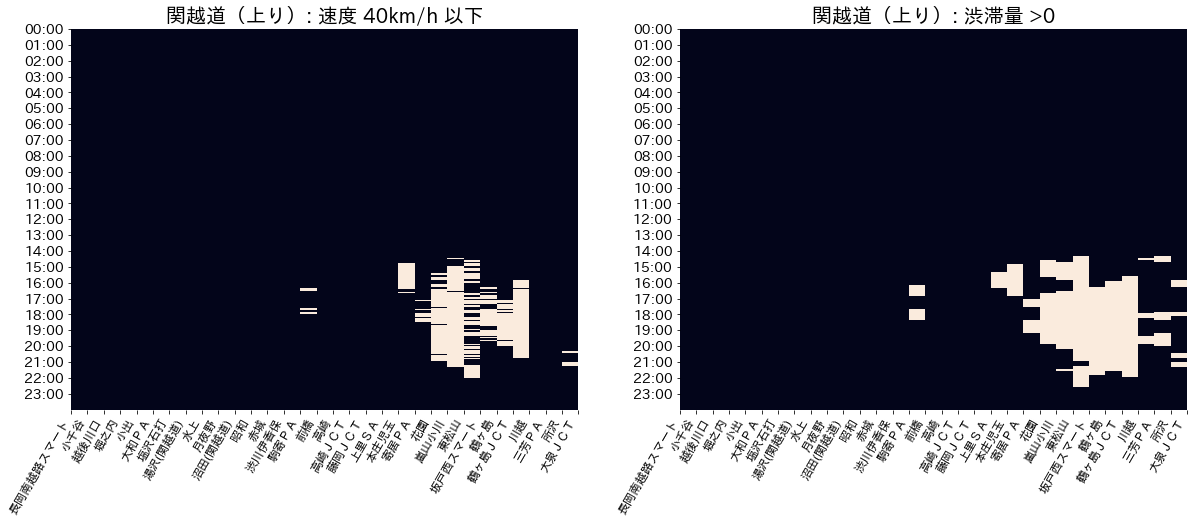

In [69]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, ts, ic_order, sr, ax=axes[0], title='関越道（上り）: 速度 40km/h 以下')
plot_heatmap(jam_up, ts, ic_order, sr, ax=axes[1], title='関越道（上り）: 渋滞量 >0')

In [89]:
date = '20220502'
sr = '5min'
direction = '上り'

df_oneday = get_oneday(df_kannetsu, date)
ic_order = get_ic_order(df_oneday, direction)

jam_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_quantity')
sp_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='speed')

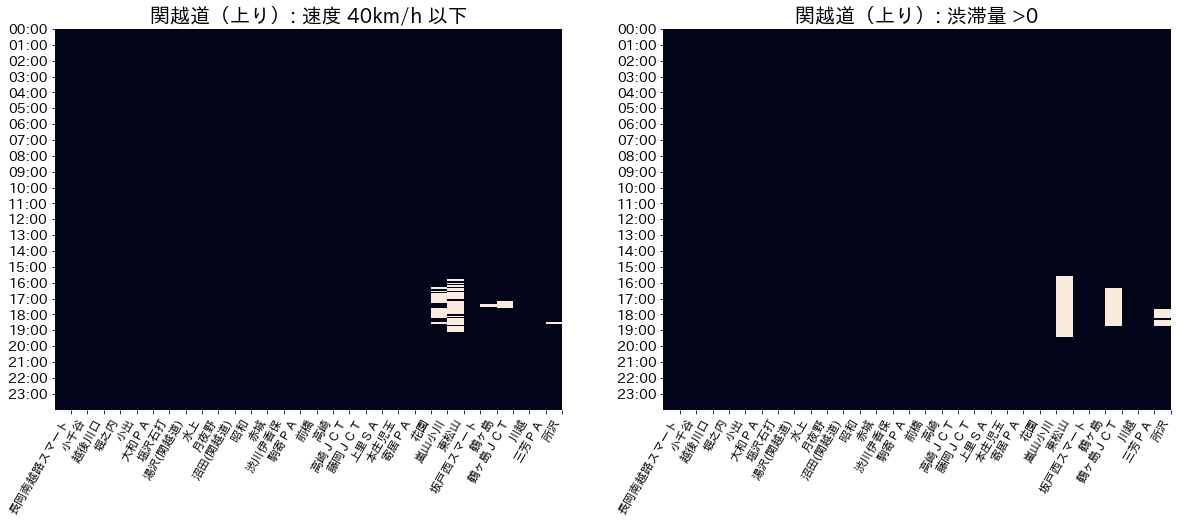

In [112]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, ts, ic_order, sr, ax=axes[0], title='関越道（上り）: 速度 40km/h 以下')
plot_heatmap(jam_up > 0, ts, ic_order, sr, ax=axes[1], title='関越道（上り）: 渋滞量 >0')

In [70]:
date = '20210809'
sr = '5min'
direction = '上り'

df_oneday = get_oneday(df_tateyama, date)
ic_order = get_ic_order(df_oneday, direction)

jam_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag')
sp_up, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='speed')

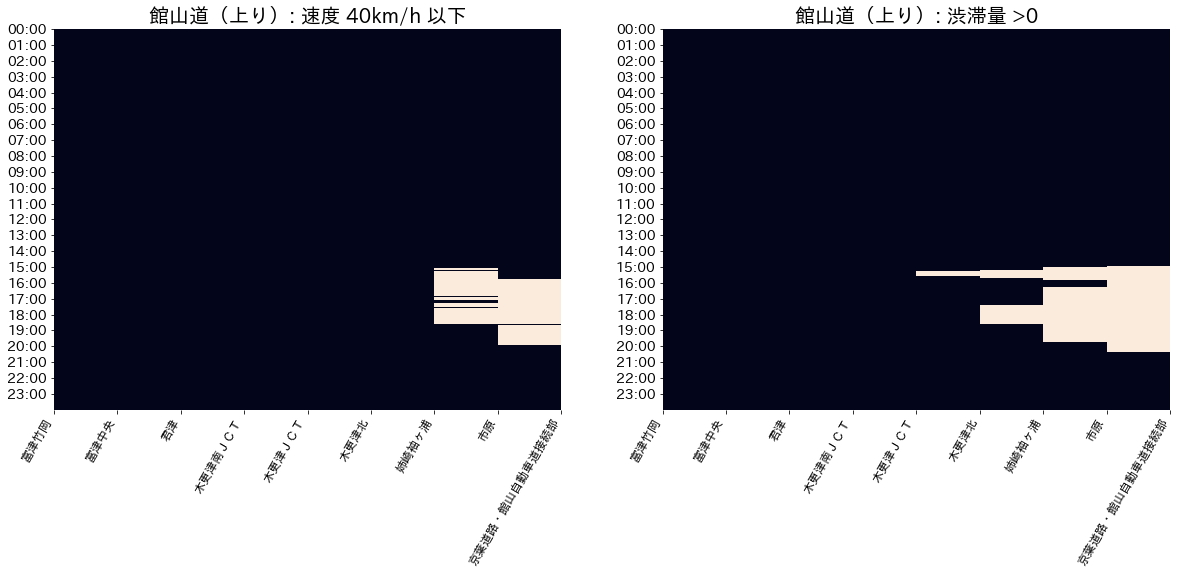

In [71]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, ts, ic_order, sr, ax=axes[0], title='館山道（上り）: 速度 40km/h 以下')
plot_heatmap(jam_up, ts, ic_order, sr, ax=axes[1], title='館山道（上り）: 渋滞量 >0')

In [134]:
start_date = '2022/4/29'
end_date = '2022/5/9'

kan_gw = df_kannetsu[(df_kannetsu['datetime'] >= pd.Timestamp(start_date)) & (df_kannetsu['datetime'] < pd.Timestamp(end_date))]

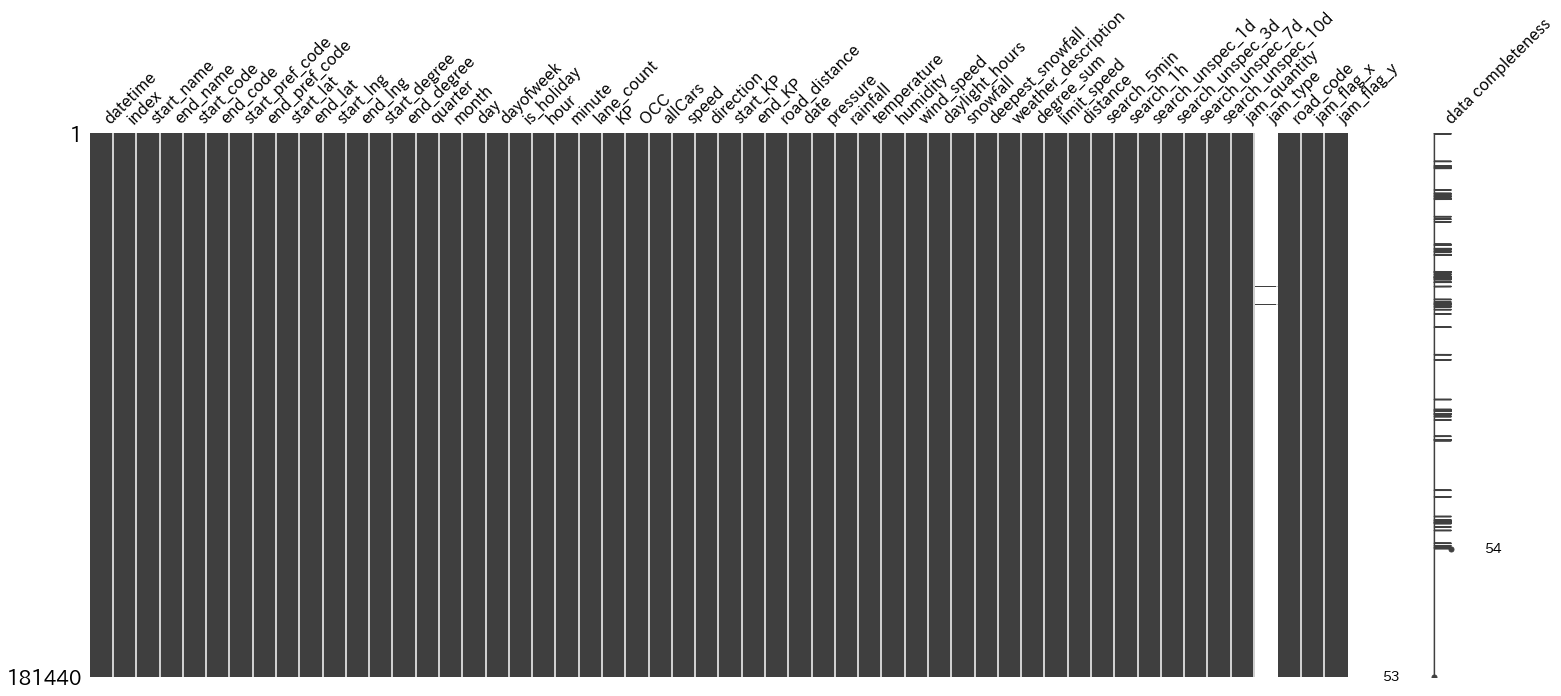

In [151]:
tmp = pd.merge(kan_gw, df_kan_pred, how='left', on=['datetime', 'start_code', 'end_code', 'road_code'])
msno.matrix(tmp, labels=True)
plt.show()

In [152]:
tp = (tmp['jam_flag_x'] & tmp['jam_flag_y']).sum()
fp = (~tmp['jam_flag_x'] & tmp['jam_flag_y']).sum()
fn = (tmp['jam_flag_x'] & ~tmp['jam_flag_y']).sum()
tn = (~tmp['jam_flag_x'] & ~tmp['jam_flag_y']).sum()

conf = np.array([[tp, fp], [fn, tn]])
print(conf)

acc = (tp + tn) / conf.sum()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fval = 2 * precision * recall / (precision + recall)

print('accuracy:\t', acc)
print('precision:\t', precision)
print('recall:\t\t', recall)
print('f1 score:\t', fval)

[[   921   3535]
 [   920 176064]]
accuracy:	 0.9754464285714286
precision:	 0.20668761220825851
recall:		 0.5002715915263444
f1 score:	 0.2925202477370176


In [172]:
start_date = '2022/4/29'
end_date = '2022/5/9'

DAYS = [d.strftime('%Y%m%d') for d in pd.date_range(start_date, end_date, inclusive='left')]

sr = '5min'
direction = '上り'

jam_true_list = []
jam_pred_list = []

for i, date in enumerate(DAYS):
    print(f'------- {date} --------')
    df_oneday = get_oneday(tmp, date)
    
    if i == 0:
        ic_order = get_ic_order(df_oneday, direction)

    jam_true, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_x')
    jam_pred, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_y')
    
    jam_true_list.append(jam_true)
    jam_pred_list.append(jam_pred)

------- 20220429 --------
------- 20220430 --------
------- 20220501 --------
------- 20220502 --------
------- 20220503 --------
------- 20220504 --------
------- 20220505 --------
------- 20220506 --------
------- 20220507 --------
------- 20220508 --------


In [154]:
date = '20220502'
sr = '5min'
direction = '上り'

df_oneday = get_oneday(tmp, date)
ic_order = get_ic_order(df_oneday, direction)

jam_true, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_x')
jam_pred, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_y')

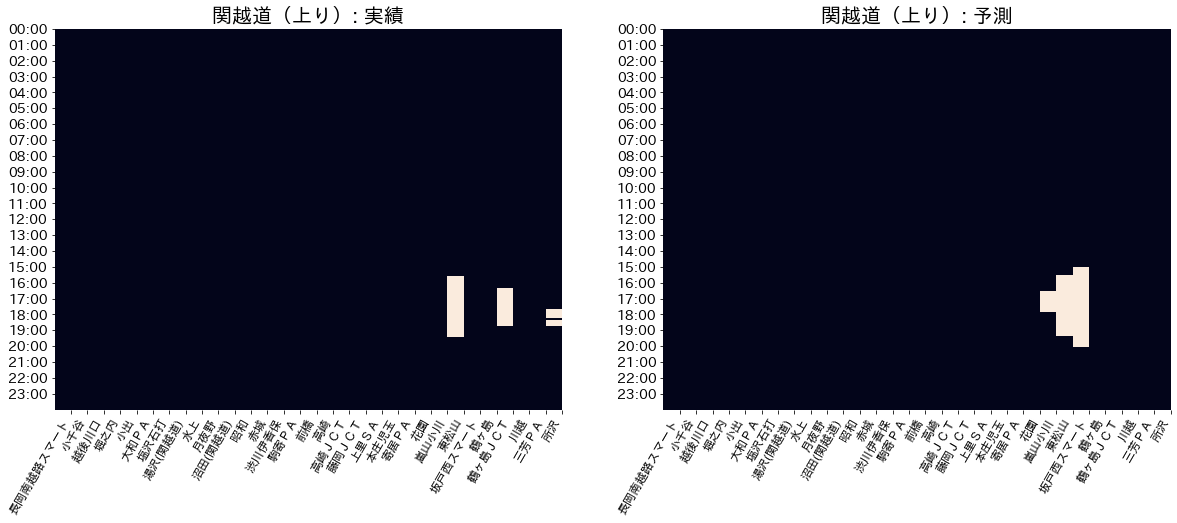

In [156]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(jam_true, ts, ic_order, sr, ax=axes[0], title='関越道（上り）: 実績')
plot_heatmap(jam_pred, ts, ic_order, sr, ax=axes[1], title='関越道（上り）: 予測')

In [165]:
start_date = '2022/4/29'
end_date = '2022/5/9'

DAYS = [d.strftime('%Y%m%d') for d in pd.date_range(start_date, end_date, inclusive='left')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

sr = '5min'

for d in tqdm.tqdm(DAYS):
    df_oneday = get_oneday(tmp, d)
    
    direction = '上り'
    ic_order = get_ic_order(df_oneday, direction)
    jam_true, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_x')
    jam_pred, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_y')
    intersec['up'] += ((jam_true > 0) & (jam_pred > 0)).sum()
    union['up'] += ((jam_true > 0) | (jam_pred > 0)).sum() 
    
    direction = '下り'
    ic_order = get_ic_order(df_oneday, direction)
    jam_true, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_x')
    jam_pred, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='jam_flag_y')
    intersec['down'] += ((jam_true > 0) & (jam_pred > 0)).sum()
    union['down'] += ((jam_true > 0) | (jam_pred > 0)).sum()

100% 10/10 [07:22<00:00, 44.27s/it]


In [166]:
print(intersec['down'] / union['down'])
print(intersec['up'] / union['up'])
print((intersec['down'] + intersec['up']) / (union['down'] + union['up']))

0.18723201524535493
0.16286243059839606
0.17243961804905447


In [262]:
def get_road_graph(df, road_code, direction='down'):
    '''
    特定の路線上のICのみから構成されるグラフを取得する関数
    （後のヒートマップによる可視化のために一直線のグラフを構築したい 
    → 上り・下りの違いで分岐が発生する路線（e.g. 東北道）が存在するためdirectionを指定する）

    Parameters
    --------------
    df: pandas.DataFrame
    ICの接続関係が格納されたデータフレーム
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    road_graph: nx.DiGraph
    指定された路線上, 指定された方向のICのグラフ
    '''
    # 引数で指定した特定路線についての接続関係のみを抽出
    df = df[df['road_code'] == road_code]

    # ICグラフを構築
    road_graph = nx.from_pandas_edgelist(df, source='start_code', target='end_code',
                                      edge_attr=['direction'],
                                      create_using=nx.DiGraph())

    # 「上り or 下り」によってエッジの向きを変更
    # （これは後に路線上のICの順番をグラフから正しく取り出せるようにするための処理）
    if direction == 'down':
        sub_list = [(s, t, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '下り']
    elif direction == 'up':
        sub_list = [(t, s, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '上り']
    else:
        assert False, 'direction should be either down or up'
  
    # 路線, 方向（上り, 下り）が限定されたICのグラフを構築
    road_graph = nx.DiGraph()
    road_graph.add_edges_from(sub_list)

    return road_graph


def get_ic_order(df, road_code, direction='down'):
    '''
    特定路線上のICの順番をDict形式で取得する関数

    Parameters
    --------------
    df: pandas.DataFrame
    ICグラフの元になる接続関係データ
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    ic_order_map: Dict[str, int]
    ICコード => 順番のマップ
    '''
    # 特定路線, 特定方向のICグラフを構築
    road_graph = get_road_graph(df, road_code, direction)

    # グラフのtraverseによって各ノード(IC)の順番を取得
    if direction == 'down':
        nodes = nx.dfs_postorder_nodes(road_graph)
        nodes = list(nodes)[::-1]
    elif direction == 'up':
        nodes = nx.dfs_postorder_nodes(road_graph)
    else:
        assert False, 'direction should be either down or up'
  
    ic_order_map = {code: i for i, code in enumerate(nodes)}

    return ic_order_map

In [266]:
order_tateyama = {
    'down': get_ic_order(df_icnet, '1130', direction='down'),
    'up': get_ic_order(df_icnet, '1130', direction='up')
}

order_kannetsu = {
    'down': get_ic_order(df_icnet, '1800', direction='down'),
    'up': get_ic_order(df_icnet, '1800', direction='up')
}

In [273]:
def init_congmat(sr, start, end=None, road_code='1130'):
    if sr[-1] == 'd':
        dt_format = '%Y-%m-%d'
        ts = [d.strftime(dt_format) for d in pd.date_range(start, end, freq=sr)]
    elif sr[-1] == 'h':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24 / int(sr[:-1]), freq=sr)]
    elif sr[-3:] == 'min':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24* (60 / int(sr[:-3])), freq=sr)]
    else:
        assert False, 'sr must be {1d, 1h, 5min}'

    n_ts = len(ts)

    if road_code == '1130':
        n_nodes_down = len(order_tateyama['down'])
        n_nodes_up = len(order_tateyama['up'])
    elif road_code == '1800':
        n_nodes_down = len(order_kannetsu['down'])
        n_nodes_up = len(order_kannetsu['up'])
    else:
        assert False, 'road_code must be {1130, 1800}'
  
    cong_mat_down = np.zeros((n_ts, n_nodes_down-1), dtype=int)
    cong_mat_up = np.zeros((n_ts, n_nodes_up-1), dtype=int)

    return cong_mat_down, cong_mat_up, ts


def get_congmat(df, sr, start, end=None, road_code='1130', time_col='datetime', num_col='allCars'):
    def f(arr, mat_down, mat_up, ic_order, ts_map):
        t = arr[time_col].strftime('%Y-%m-%d')
        if t not in ts_map:
            t = arr[time_col].strftime('%Y-%m-%d %H:%M')
        if t not in ts_map:
            return False

        start, end, n = arr[['start_code', 'end_code', num_col]]

        if ic_graph[start][end]['direction'] == '下り':
            ind = ic_order['down'][start]
            mat_down[ts_map[t], ind] = n
        else:
            ind = ic_order['up'][start]
            mat_up[ts_map[t], ind] = n

        return True

    if road_code == '1130':
        order = order_tateyama
    elif road_code == '1800':
        order = order_kannetsu
    else:
        assert False, 'road_code must be {1130, 1800}'

    mat_d, mat_u, ts = init_congmat(sr, start, end, road_code)

    ts_map = {t: i for i, t in enumerate(ts)}

    df.apply(f, axis=1, args=[mat_d, mat_u, order, ts_map])

    return mat_d, mat_u, ts

In [406]:
def plot_heatmap(mat, xlabel, ylabel, title, xticklabels, yticklabels, ax, fontdict_x={}, fontdict_y={}):
    xticks = range(len(xticklabels))
    yticks = range(0, mat.shape[0], 12)

    ## plot ##
    # fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    sns.heatmap(mat, cbar=False, ax=ax)

    ## config ##
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20)

    ax.set_xticks(xticks)
    fontdict_x.update({
        'fontsize': 12,
        'horizontalalignment': 'right',
    })
    ax.set_xticklabels(labels=xticklabels, fontdict=fontdict_x, rotation=60)

    ax.set_yticks(ticks=yticks)
    fontdict_y.update({
        'fontsize': 14,
        'verticalalignment': 'center_baseline',
    })
    ax.set_yticklabels(labels=yticklabels, fontdict=fontdict_y, rotation=360)

    # plt.show()

In [207]:
df_tateyama['speed'].fillna(method='ffill', inplace=True)
df_kannetsu['speed'].fillna(method='ffill', inplace=True)

In [267]:
def get_oneday(df, year, month, day):
    return df[df['datetime'].dt.date == dt.date(year, month, day)]

In [ ]:
DAYS = [d.strftime('%Y%m%d') for d in pd.date_range('20210401', '20211231')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

for d in tqdm.tqdm(DAYS):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[6:])
    tmp = get_oneday(df_kannetsu, year, month, day)
    
    sp_down, sp_up, ts = get_congmat(tmp, '5min', d, road_code='1800', num_col='speed')
    jam_down, jam_up, ts = get_congmat(tmp, '5min', d, road_code='1800', num_col='jam_quantity')
    
    intersec['down'] += ((sp_down <= 40) & (jam_down > 0)).sum()
    intersec['up'] += ((sp_up <= 40) & (jam_up > 0)).sum()
    union['down'] += ((sp_down <= 40) | (jam_down > 0)).sum()
    union['up'] += ((sp_up <= 40) | (jam_up > 0)).sum()    

In [345]:
intersec, union

({'down': 3999, 'up': 7436}, {'down': 13055, 'up': 20010})

In [347]:
intersec['down'] / union['down']

0.306319417847568

In [349]:
intersec['up'] / union['up']

0.37161419290354825

In [350]:
(intersec['down'] + intersec['up']) / (union['down'] + union['up'])

0.34583396340541356

In [421]:
DAYS = [d.strftime('%Y%m%d') for d in pd.date_range('20210401', '20211231')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

for d in tqdm.tqdm(DAYS):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[6:])
    tmp = get_oneday(df_tateyama, year, month, day)
    
    sp_down, sp_up, ts = get_congmat(tmp, '5min', d, road_code='1130', num_col='speed')
    jam_down, jam_up, ts = get_congmat(tmp, '5min', d, road_code='1130', num_col='jam_quantity')
    
    intersec['down'] += ((sp_down <= 40) & (jam_down > 0)).sum()
    intersec['up'] += ((sp_up <= 40) & (jam_up > 0)).sum()
    union['down'] += ((sp_down <= 40) | (jam_down > 0)).sum()
    union['up'] += ((sp_up <= 40) | (jam_up > 0)).sum()    

100% 275/275 [27:17<00:00,  5.95s/it]


In [422]:
intersec['down'] / union['down']

0.30303030303030304

In [423]:
intersec['up'] / union['up']

0.4306306306306306

In [424]:
(intersec['down'] + intersec['up']) / (union['down'] + union['up'])

0.3801742919389978

## 15分単位

In [413]:
def plot_heatmap(mat, xlabel, ylabel, title, xticklabels, yticklabels, ax, fontdict_x={}, fontdict_y={}):
    xticks = range(len(xticklabels))
    yticks = range(0, mat.shape[0], 4)

    ## plot ##
    # fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    sns.heatmap(mat, cbar=False, ax=ax)

    ## config ##
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20)

    ax.set_xticks(xticks)
    fontdict_x.update({
        'fontsize': 12,
        'horizontalalignment': 'right',
    })
    ax.set_xticklabels(labels=xticklabels, fontdict=fontdict_x, rotation=60)

    ax.set_yticks(ticks=yticks)
    fontdict_y.update({
        'fontsize': 14,
        'verticalalignment': 'center_baseline',
    })
    ax.set_yticklabels(labels=yticklabels, fontdict=fontdict_y, rotation=360)

    # plt.show()

In [384]:
kan_15min = pd.read_csv(TRAFFIC_KANNETSU_15MIN_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index()
kan_15min.replace({'1800146': '1800151', '1800072': '1800073'}, inplace=True)

tat_15min = pd.read_csv(TRAFFIC_TATEYAMA_15MIN_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index()
tat_15min.replace('1130039', '1130036', inplace=True)

In [441]:
code2name['1130039'], code2name['1130036']

('君津ＰＡ', '君津')

In [385]:
kan_15min['speed'].fillna(method='ffill', inplace=True)
tat_15min['speed'].fillna(method='ffill', inplace=True)

In [387]:
road_code = '1800'
day = '20210504'
df_day = get_oneday(kan_15min, 2021, 5, 4)
sr = '15min'

sp_down, sp_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='speed')
jam_down, jam_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='jam_quantity')

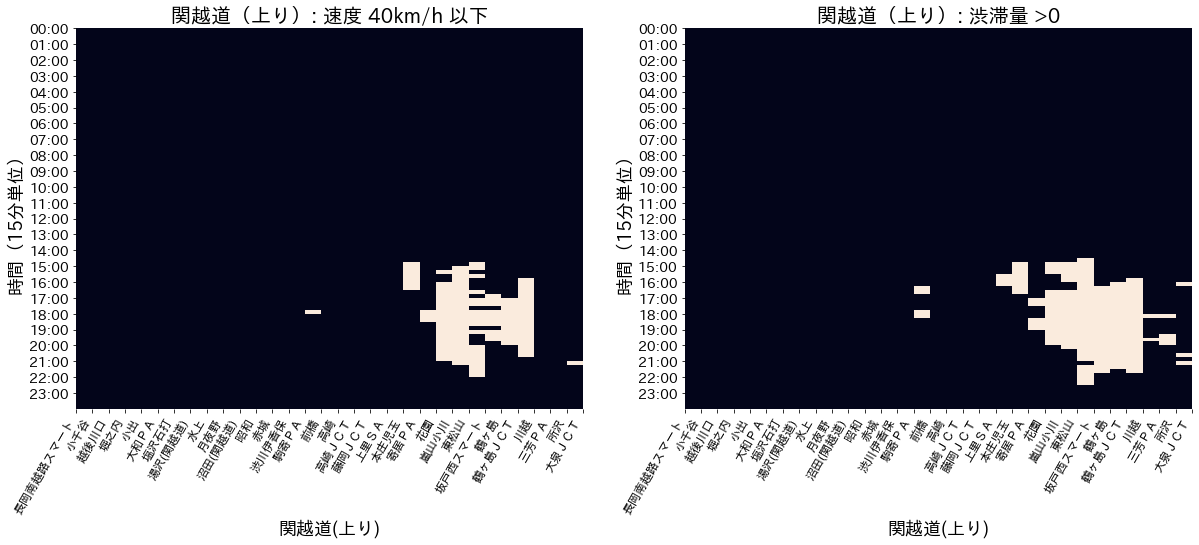

In [398]:
xlabel = '関越道(上り)'
ylabel = '時間（15分単位）'
title0 = '関越道（上り）: 速度 40km/h 以下'
title1 = '関越道（上り）: 渋滞量 >0'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 4)]

fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, xlabel, ylabel, title0, xticklabels, yticklabels, ax=axes[0])
plot_heatmap(jam_up > 0, xlabel, ylabel, title1, xticklabels, yticklabels, ax=axes[1])

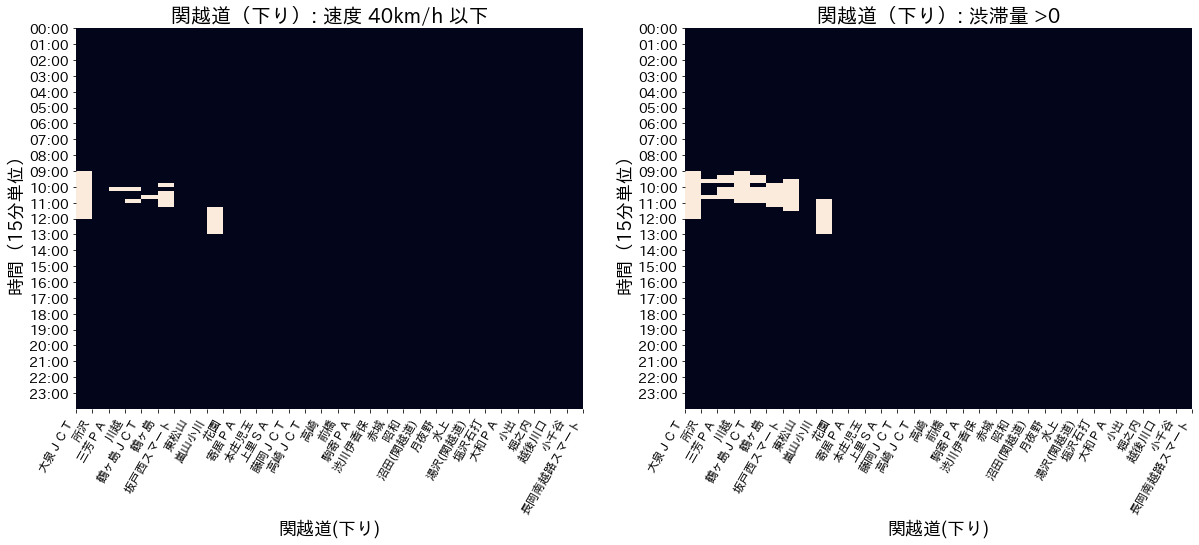

In [399]:
xlabel = '関越道(下り)'
ylabel = '時間（15分単位）'
title0 = '関越道（下り）: 速度 40km/h 以下'
title1 = '関越道（下り）: 渋滞量 >0'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 4)]

fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_down < 40, xlabel, ylabel, title0, xticklabels, yticklabels, ax=axes[0])
plot_heatmap(jam_down > 0, xlabel, ylabel, title1, xticklabels, yticklabels, ax=axes[1])

In [417]:
road_code = '1130'
day = '20210809'
df_day = get_oneday(tat_15min, 2021, 8, 9)
sr = '15min'

sp_down, sp_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='speed')
jam_down, jam_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='jam_quantity')

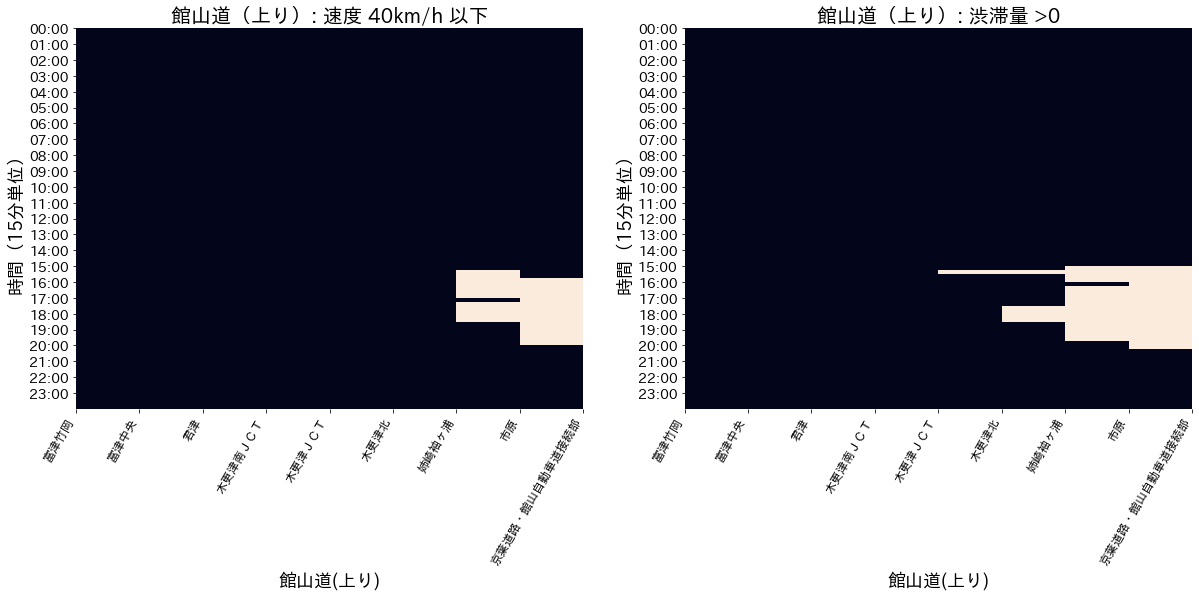

In [418]:
xlabel = '館山道(上り)'
ylabel = '時間（15分単位）'
title0 = '館山道（上り）: 速度 40km/h 以下'
title1 = '館山道（上り）: 渋滞量 >0'

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 4)]

fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, xlabel, ylabel, title0, xticklabels, yticklabels, ax=axes[0])
plot_heatmap(jam_up > 0, xlabel, ylabel, title1, xticklabels, yticklabels, ax=axes[1])

In [371]:
DAYS = [d.strftime('%Y%m%d') for d in pd.date_range('20210401', '20211231')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

for d in tqdm.tqdm(DAYS):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[6:])
    tmp = get_oneday(kan_15min, year, month, day)
    
    sp_down, sp_up, ts = get_congmat(tmp, '15min', d, road_code='1800', num_col='speed')
    jam_down, jam_up, ts = get_congmat(tmp, '15min', d, road_code='1800', num_col='jam_quantity')
    
    intersec['down'] += ((sp_down <= 40) & (jam_down > 0)).sum()
    intersec['up'] += ((sp_up <= 40) & (jam_up > 0)).sum()
    union['down'] += ((sp_down <= 40) | (jam_down > 0)).sum()
    union['up'] += ((sp_up <= 40) | (jam_up > 0)).sum()
    
    
intersec, union

100% 275/275 [35:55<00:00,  7.84s/it]


({'down': 1425, 'up': 2592}, {'down': 4112, 'up': 6579})

In [432]:
kan_15min.shape

(2703456, 47)

In [435]:
tmp = get_oneday(kan_15min, 2021, 4, 1)
jam_down, jam_up, ts = get_congmat(tmp, '15min', d, road_code='1800', num_col='jam_quantity')
jam_down.shape

(96, 31)

In [439]:
jam_down.shape[0] * jam_down.shape[1] * len(DAYS)

818400

In [372]:
intersec['down'] / union['down']

0.3465466926070039

In [373]:
intersec['up'] / union['up']

0.39398084815321477

In [374]:
(intersec['down'] + intersec['up']) / (union['down'] + union['up'])

0.3757366008792442

In [451]:
pred = pd.read_csv('../Input_processed_data/jam_data/jam_prediction_R4GW.csv',
                  index_col='datetime', parse_dates=True, dtype=col_types).reset_index()
pred.head()

,datetime,start_code,end_code,jam_flag,road_code
0,2022-04-28,1800001,1110210,False,1800
1,2022-04-28,1110210,1800004,False,1800
2,2022-04-28,1110210,1800001,False,1800
3,2022-04-28,1800004,1800006,False,1800
4,2022-04-28,1800004,1110210,False,1800


In [471]:
kan_pred = pred[pred['road_code'] == '1800'].reset_index(drop=True)
tmp = kan_pred[(kan_pred['datetime'] >= pd.Timestamp('2022/5/3')) & (kan_pred['datetime'] < pd.Timestamp('2022/5/4'))]
tmp

,datetime,start_code,end_code,jam_flag,road_code
138240,2022-05-03 00:00:00,1800001,1110210,False,1800
138241,2022-05-03 00:00:00,1110210,1800004,False,1800
138242,2022-05-03 00:00:00,1110210,1800001,False,1800
138243,2022-05-03 00:00:00,1800004,1800006,False,1800
138244,2022-05-03 00:00:00,1800004,1110210,False,1800
...,...,...,...,...,...
165883,2022-05-03 23:55:00,1800183,1800186,False,1800
165884,2022-05-03 23:55:00,1800183,1800181,False,1800
165885,2022-05-03 23:55:00,1800186,1080291,False,1800
165886,2022-05-03 23:55:00,1800186,1800183,False,1800


In [472]:
tmp.reset_index(drop=True, inplace=True)

In [474]:
tmp['jam_flag'] = tmp['jam_flag'].astype(int)

/tmp/ipykernel_1319312/2042500419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['jam_flag'] = tmp['jam_flag'].astype(int)


In [387]:
road_code = '1800'
day = '20210503'
sr = '5min'

sp_down, sp_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='')
jam_down, jam_up, ts = get_congmat(df_day, sr, day, road_code=road_code, num_col='jam_quantity')

In [460]:
code2name['1800161']

'堀之内'

In [461]:
code2name['1800171']

'越後川口'

In [463]:
tmp = pd.read_csv(f'../Input_processed_data/jam_data/jam_prediction_R4GW.csv')
tmp

,datetime,start_code,end_code,jam_flag,road_code
0,2022-04-28 00:00:00,1800001,1110210,False,1800
1,2022-04-28 00:00:00,1110210,1800004,False,1800
2,2022-04-28 00:00:00,1110210,1800001,False,1800
3,2022-04-28 00:00:00,1800004,1800006,False,1800
4,2022-04-28 00:00:00,1800004,1110210,False,1800
...,...,...,...,...,...
373819,2022-05-08 23:55:00,1130039,1130036,False,1130
373820,2022-05-08 23:55:00,1130041,1130046,False,1130
373821,2022-05-08 23:55:00,1130041,1130039,False,1130
373822,2022-05-08 23:55:00,1130046,1130041,False,1130


In [469]:
code2name['1800166']

'越後川口ＳＡ'

In [468]:
tmp[tmp['start_code'] == 1800161]

,datetime,start_code,end_code,jam_flag,road_code
81,2022-04-28 00:00:00,1800161,1800166,False,1800
82,2022-04-28 00:00:00,1800161,1800159,False,1800
199,2022-04-28 00:05:00,1800161,1800166,False,1800
200,2022-04-28 00:05:00,1800161,1800159,False,1800
317,2022-04-28 00:10:00,1800161,1800166,False,1800
...,...,...,...,...,...
373552,2022-05-08 23:45:00,1800161,1800159,False,1800
373669,2022-05-08 23:50:00,1800161,1800166,False,1800
373670,2022-05-08 23:50:00,1800161,1800159,False,1800
373787,2022-05-08 23:55:00,1800161,1800166,False,1800


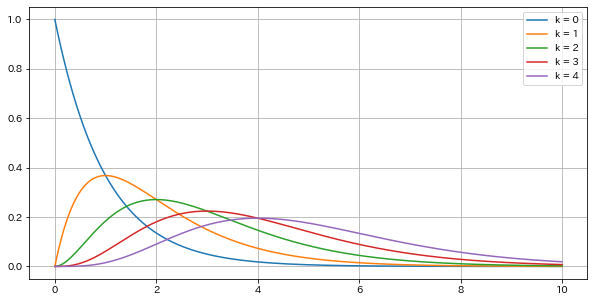

In [187]:
xs = np.linspace(0, 10, 500)

p = lambda k: lambda lt: lt**k / np.math.factorial(k) * np.exp(-lt)

klist = np.arange(5)

fig, ax = plt.subplots(figsize=(10, 5))

for k in klist:
    ax.plot(xs, p(k)(xs), label=f'k = {k}')
ax.legend()
ax.grid()

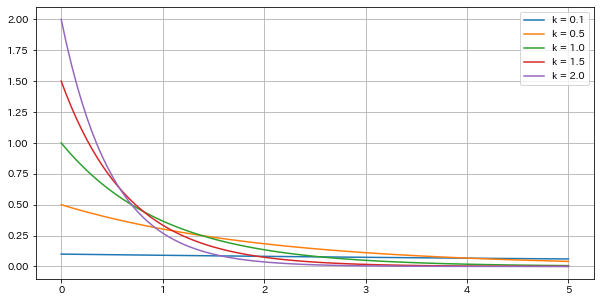

In [191]:
xs = np.linspace(0, 5, 100)

p = lambda lm: lambda x: lm * np.exp(-lm * x)

mu_list = [0.1, 0.5, 1.0, 1.5, 2.0]

fig, ax = plt.subplots(figsize=(10, 5))

for mu in mu_list:
    ax.plot(xs, p(mu)(xs), label=f'k = {mu}')
ax.legend()
ax.grid()